In [1]:
import numpy as np 
import pandas as pd 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
ret_df = pd.read_csv('s&p100ret.csv')
ret_df

/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_49448/4274169517.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ret_df = pd.read_csv('s&p100ret.csv')


,PERMNO,date,TICKER,RET
0,10104,2019-01-02,ORCL,0.001550
1,10104,2019-01-03,ORCL,-0.009730
2,10104,2019-01-04,ORCL,0.043100
3,10104,2019-01-07,ORCL,0.015842
4,10104,2019-01-08,ORCL,0.009062
...,...,...,...,...
154368,93436,2024-12-24,TSLA,0.073572
154369,93436,2024-12-26,TSLA,-0.01763
154370,93436,2024-12-27,TSLA,-0.049479
154371,93436,2024-12-30,TSLA,-0.033012


In [16]:
ret_df['TICKER'] = ret_df['TICKER'].str.strip() 
ret_df['RET'] = pd.to_numeric(ret_df['RET'], errors='coerce') 
ret_df['date'] = pd.to_datetime(ret_df['date'], format='%Y-%m-%d')


In [7]:
ret_df['TICKER'].unique().shape

(105,)

In [11]:
ret_df['RET'].isna().sum()

0

In [14]:
#get datatyoe of data column 
ret_df.dtypes

PERMNO     int64
date      object
TICKER    object
RET       object
dtype: object

In [ ]:
import pandas as pd
import numpy as np

def compute_ticker_momentum_weekly(
    ret_df: pd.DataFrame,
    lookback_weeks: int = 52,
    skip_weeks: int = 4,
    week_rule: str = "W-FRI",
    col_ticker: str = "TICKER",
    col_date: str = "date",
    col_ret: str = "RET",
    out_mom: str = "MOM",
    out_wret: str = "WRET",
    return_daily_aligned: bool = False,
    ffill_to_next_week: bool = False
) -> pd.DataFrame:
    """
    Weekly L–G momentum using *weekly* compounded returns, also includes weekly returns.

    Momentum on week t is cumulative return from [t-(G+L)+1, ..., t-G] in weeks.

    If return_daily_aligned=False -> returns a weekly panel (PERMNO-week level).
    If return_daily_aligned=True  -> merges weekly MOM and weekly RET back to the daily panel.
    """
    df = ret_df.copy()
    df[col_date] = pd.to_datetime(df[col_date])
    df = df.sort_values([col_ticker, col_date])

    # === 1. Convert daily returns to weekly log-returns ===
    df["_logret"] = np.log1p(df[col_ret].astype(float).fillna(0.0).clip(lower=-0.999999))

    # === 2. Resample to weekly frequency per ticker ===
    wk = (
        df.set_index(col_date)
          .groupby(col_ticker, group_keys=True)["_logret"]
          .resample(week_rule)
          .sum()
          .rename("logret_w")
          .reset_index()
    )

    # Weekly compounded simple return
    wk[out_wret] = np.expm1(wk["logret_w"])

    # === 3. Compute cumulative sums of weekly log returns ===
    wk["csum"] = wk.groupby(col_ticker)["logret_w"].cumsum()

    # End of window: t - G
    wk["csum_end"] = wk.groupby(col_ticker)["csum"].shift(skip_weeks)

    # Start of window: t - (L+G)
    wk["csum_start"] = wk.groupby(col_ticker)["csum_end"].shift(lookback_weeks)

    # === 4. Momentum ===
    wk[out_mom] = np.exp(wk["csum_end"] - wk["csum_start"]) - 1.0

    wk_out = wk[[col_ticker, col_date, out_wret, out_mom]].rename(columns={col_date: "week_date"})

    # === 5. Return weekly panel ===
    if not return_daily_aligned:
        return wk_out

    # === 6. Or merge back to daily panel ===
    daily = ret_df.copy()
    daily[col_date] = pd.to_datetime(daily[col_date])

    # build mapping from each daily date to its week anchor (Friday)
    all_days = (
        daily[[col_date]]
        .drop_duplicates()
        .sort_values(col_date)
        .set_index(col_date)
    )
    anchors = all_days.resample(week_rule).last().index
    mapper = pd.Series(anchors, index=anchors)
    mapper = mapper.reindex(all_days.index, method="ffill")
    mapper.name = "week_date"
    mapper = mapper.reset_index().rename(columns={col_date: "date"})

    daily = daily.merge(mapper, left_on=col_date, right_on="date", how="left").drop(columns=["date"])
    out = daily.merge(wk_out, on=[col_ticker, "week_date"], how="left")

    if ffill_to_next_week:
        out = out.sort_values([col_ticker, col_date])
        out[[out_mom, out_wret]] = out.groupby(col_ticker)[[out_mom, out_wret]].ffill()

    return out


In [95]:
mom_weekly = compute_ticker_momentum_weekly(ret_df, lookback_weeks=12, skip_weeks=1).dropna(subset=['MOM'])
print(mom_weekly.head())


   TICKER  week_date      WRET       MOM
13   AAPL 2019-04-05  0.037114  0.286681
14   AAPL 2019-04-12  0.009492  0.299123
15   AAPL 2019-04-19  0.025091  0.273570
16   AAPL 2019-04-26  0.002159  0.297747
17   AAPL 2019-05-03  0.036466  0.232132


In [94]:
mom_weekly

,TICKER,week_date,WRET,MOM
13,AAPL,2019-04-05,0.037114,0.286681
14,AAPL,2019-04-12,0.009492,0.299123
15,AAPL,2019-04-19,0.025091,0.273570
16,AAPL,2019-04-26,0.002159,0.297747
17,AAPL,2019-05-03,0.036466,0.232132
...,...,...,...,...
32118,XOM,2024-12-06,-0.037216,0.055830
32119,XOM,2024-12-13,-0.024037,0.030164
32120,XOM,2024-12-20,-0.044840,-0.030533
32121,XOM,2024-12-27,0.005763,-0.078401


# Backtest on cross sectional momentum trading only 

In [90]:
import pandas as pd
import numpy as np

########################################
# CONFIG
########################################

LONG_PCT  = 0.1
SHORT_PCT = 0.1
LEVERAGE  = 1.0
HOLDING_WEEKS = 1

# Synthetic alpha controls
SYNTH_IC_TARGET = 0.05
SYNTH_SEED      = 42


########################################
# 1. DATA PREP
########################################

def prepare_weekly_data(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['week_date'] = pd.to_datetime(out['week_date'])
    out = out.sort_values(['TICKER','week_date'])
    out = out.dropna(subset=['WRET'])
    out = out.rename(columns={'WRET': 'RET'})   # unify column name
    return out


########################################
# 2. SYNTHETIC SIGNAL GENERATION
########################################

def _zscore(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    std = s.std(ddof=0)
    return (s - s.mean())/std if std and std > 0 else s*0.0

def add_synthetic_signal(df: pd.DataFrame,
                         rho: float = SYNTH_IC_TARGET,
                         seed: int = SYNTH_SEED) -> pd.DataFrame:
    """Generate synthetic cross-sectional signal with target IC ≈ rho vs next-week return."""
    out = df.copy()
    out['RET_fwd'] = out.groupby('TICKER')['RET'].shift(-1)
    rng = np.random.default_rng(seed)
    syn_list = []

    for d, g in out.groupby('week_date', sort=True):
        y = g['RET_fwd']
        z_y = _zscore(y)
        eps = pd.Series(rng.normal(size=len(g)), index=g.index)
        valid = z_y.notna()
        syn = pd.Series(np.nan, index=g.index)
        if valid.any():
            syn.loc[valid] = rho*z_y.loc[valid].values + np.sqrt(max(0.0,1-rho**2))*_zscore(eps.loc[valid])
        syn_list.append(syn)

    out['SYN'] = pd.concat(syn_list).sort_index()
    return out


########################################
# 3. SIGNAL FUNCTION
########################################

def make_signal(df_slice: pd.DataFrame, col_signal: str) -> pd.Series:
    """Return chosen signal column per ticker."""
    if col_signal not in df_slice.columns:
        raise KeyError(f"Signal column '{col_signal}' not found in dataframe.")
    return df_slice.set_index('TICKER')[col_signal]


########################################
# 4. WEIGHT CONSTRUCTION
########################################

def construct_weights(signal_cs: pd.Series,
                      long_pct=LONG_PCT,
                      short_pct=SHORT_PCT,
                      gross_leverage=LEVERAGE) -> pd.Series:
    sig = signal_cs.dropna()
    if sig.empty:
        return pd.Series(dtype=float)
    n = len(sig)
    n_long  = max(1, int(round(n * long_pct)))
    n_short = max(1, int(round(n * short_pct)))
    ranked = sig.sort_values(ascending=False)
    w_long  = pd.Series( 1/n_long, index=ranked.index[:n_long])
    w_short = pd.Series(-1/n_short, index=ranked.index[-n_short:])
    w = pd.concat([w_long, w_short])
    gross = w.abs().sum()
    if gross > 0:
        w *= gross_leverage / gross
    return w


########################################
# 5. BUILD WEIGHT PANEL
########################################

def build_weight_panel(df: pd.DataFrame,
                       holding_weeks: int,
                       col_signal: str) -> pd.DataFrame:
    all_weeks = sorted(df['week_date'].unique())
    recs = []

    def forward_window(start_week):
        if start_week not in all_weeks: return []
        i0 = all_weeks.index(start_week)
        i1 = i0 + holding_weeks
        return all_weeks[i0:i1]

    for w in all_weeks:
        cs_slice = df[df['week_date'] == w]
        sig_cs = make_signal(cs_slice, col_signal)
        w_cs = construct_weights(sig_cs)
        for hw in forward_window(w):
            recs.append(pd.DataFrame({
                'week_date': hw,
                'TICKER': w_cs.index,
                'weight': w_cs.values
            }))
    return pd.concat(recs, ignore_index=True)


########################################
# 6. COMPUTE PNL
########################################

def compute_pnl_timeseries(df: pd.DataFrame, weight_panel: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['RET_fwd'] = df.groupby('TICKER')['RET'].shift(-1)
    merged = pd.merge(weight_panel,
                      df[['TICKER','week_date','RET_fwd']],
                      on=['TICKER','week_date'], how='left')
    pnl = (merged
           .assign(pnl = merged['weight'] * merged['RET_fwd'])
           .groupby('week_date', as_index=False)
           .agg(port_ret=('pnl','sum')))
    pnl['cum_ret'] = (1 + pnl['port_ret']).cumprod() - 1
    return pnl


########################################
# 7. INFORMATION COEFFICIENT
########################################

def compute_weekly_ic(df: pd.DataFrame, col_signal: str) -> pd.DataFrame:
    df = df.copy()
    df['RET_fwd'] = df.groupby('TICKER')['RET'].shift(-1)

    def _ic(g):
        x, y = g[col_signal], g['RET_fwd']
        m = x.notna() & y.notna()
        if m.sum() < 3:
            return pd.Series({'pearson_ic': np.nan, 'spearman_ic': np.nan})
        pear = np.corrcoef(x[m], y[m])[0,1]
        spear = pd.Series(x[m]).rank().corr(pd.Series(y[m]).rank())
        return pd.Series({'pearson_ic': pear, 'spearman_ic': spear})

    ic_df = df.groupby('week_date').apply(_ic).reset_index()
    return ic_df


########################################
# 8. MASTER DRIVER
########################################

def run_weekly_backtest(
    mom_weekly: pd.DataFrame,
    col_signal: str = "MOM",       # which signal column to use
    use_synthetic: bool = False,   # if True, auto-generate SYN with target IC
    rho: float = SYNTH_IC_TARGET,
    seed: int = SYNTH_SEED
) -> dict:
    """
    Unified weekly backtest:
      - If use_synthetic=True: auto-create synthetic alpha with target IC.
      - Else: use the specified column as the trading signal.
    """
    df = prepare_weekly_data(mom_weekly)

    # Generate synthetic signal if requested
    if use_synthetic:
        df = add_synthetic_signal(df, rho=rho, seed=seed)
        col_signal = "SYN"  # override column name

    weight_panel = build_weight_panel(df, holding_weeks=HOLDING_WEEKS, col_signal=col_signal)
    weekly_perf = compute_pnl_timeseries(df, weight_panel)
    ic_df = compute_weekly_ic(df, col_signal)

    avg_w = weekly_perf['port_ret'].mean()
    vol_w = weekly_perf['port_ret'].std(ddof=1)
    sharpe_w = (avg_w / vol_w * np.sqrt(52)) if vol_w and vol_w > 0 else np.nan

    summary = {
        'start': weekly_perf['week_date'].min(),
        'end': weekly_perf['week_date'].max(),
        'total_return': weekly_perf['cum_ret'].iloc[-1],
        'avg_weekly_ret': avg_w,
        'weekly_vol': vol_w,
        'annualized_sharpe': sharpe_w,
        'mean_ic': ic_df['pearson_ic'].mean(),
        'signal_used': col_signal,
        'synthetic_used': use_synthetic,
        'target_ic': rho if use_synthetic else None,
        'n_rebalances': len(df['week_date'].unique())
    }

    return {
        'weekly_perf': weekly_perf,
        'weights': weight_panel,
        'ic': ic_df,
        'summary': summary
    }



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_49448/1986402521.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic_df = df.groupby('week_date').apply(_ic).reset_index()


<Axes: title={'center': 'Weekly Momentum Backtest'}, xlabel='week_date'>

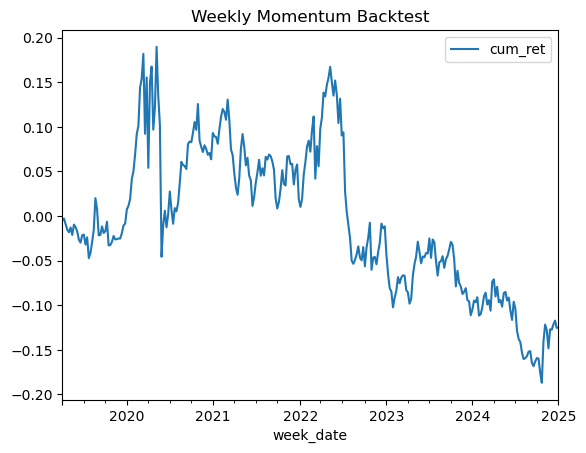

In [ ]:
result_real = run_weekly_backtest(mom_weekly, col_signal="MOM", use_synthetic=False)
result_real['weekly_perf'][['week_date','cum_ret']].plot(x='week_date', y='cum_ret', title='Weekly Momentum Backtest')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_49448/1986402521.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic_df = df.groupby('week_date').apply(_ic).reset_index()


<Axes: title={'center': 'Weekly Alpha Backtest'}, xlabel='week_date'>

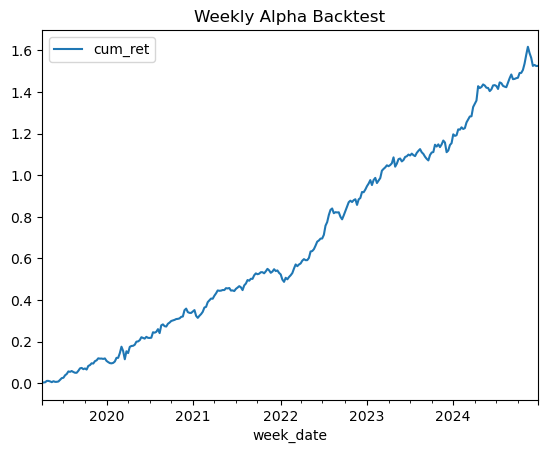

In [93]:
result_syn = run_weekly_backtest(mom_weekly, use_synthetic=True, rho=0.05)
result_syn['weekly_perf'][['week_date','cum_ret']].plot(x='week_date', y='cum_ret', title='Weekly Alpha Backtest')